# Exploration And Model Evalutation for Our House Princing Prediction Pipeline

In [36]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train_data = pd.read_csv("/content/housing_raw_data.csv")
predict_data = pd.read_csv("/content/housing_daily_data.csv")


In [7]:
train_data.head()

,Id,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,BsmtFinSF2,TotalBsmtSF,SalePrice
0,0,60,RL,8450,Inside,1Fam,5,2003,2003,VinylSd,0,856,208500
1,1,20,RL,9600,FR2,1Fam,8,1976,1976,MetalSd,0,1262,181500
2,2,60,RL,11250,Inside,1Fam,5,2001,2002,VinylSd,0,920,223500
3,3,70,RL,9550,Corner,1Fam,5,1915,1970,Wd Sdng,0,756,140000
4,4,60,RL,14260,FR2,1Fam,5,2000,2000,VinylSd,0,1145,250000


In [9]:
train_data.describe()

,Id,MSSubClass,LotArea,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,TotalBsmtSF,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,729.500000,56.897260,10516.828082,5.575342,1971.267808,1984.865753,46.549315,1057.429452,180921.195890
std,421.610009,42.300571,9981.264932,1.112799,30.202904,20.645407,161.319273,438.705324,79442.502883
min,0.000000,20.000000,1300.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,34900.000000
25%,364.750000,20.000000,7553.500000,5.000000,1954.000000,1967.000000,0.000000,795.750000,129975.000000
50%,729.500000,50.000000,9478.500000,5.000000,1973.000000,1994.000000,0.000000,991.500000,163000.000000
75%,1094.250000,70.000000,11601.500000,6.000000,2000.000000,2004.000000,0.000000,1298.250000,214000.000000
max,1459.000000,190.000000,215245.000000,9.000000,2010.000000,2010.000000,1474.000000,6110.000000,755000.000000


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            1460 non-null   int64 
 1   MSSubClass    1460 non-null   int64 
 2   MSZoning      1460 non-null   object
 3   LotArea       1460 non-null   int64 
 4   LotConfig     1460 non-null   object
 5   BldgType      1460 non-null   object
 6   OverallCond   1460 non-null   int64 
 7   YearBuilt     1460 non-null   int64 
 8   YearRemodAdd  1460 non-null   int64 
 9   Exterior1st   1460 non-null   object
 10  BsmtFinSF2    1460 non-null   int64 
 11  TotalBsmtSF   1460 non-null   int64 
 12  SalePrice     1460 non-null   int64 
dtypes: int64(9), object(4)
memory usage: 148.4+ KB


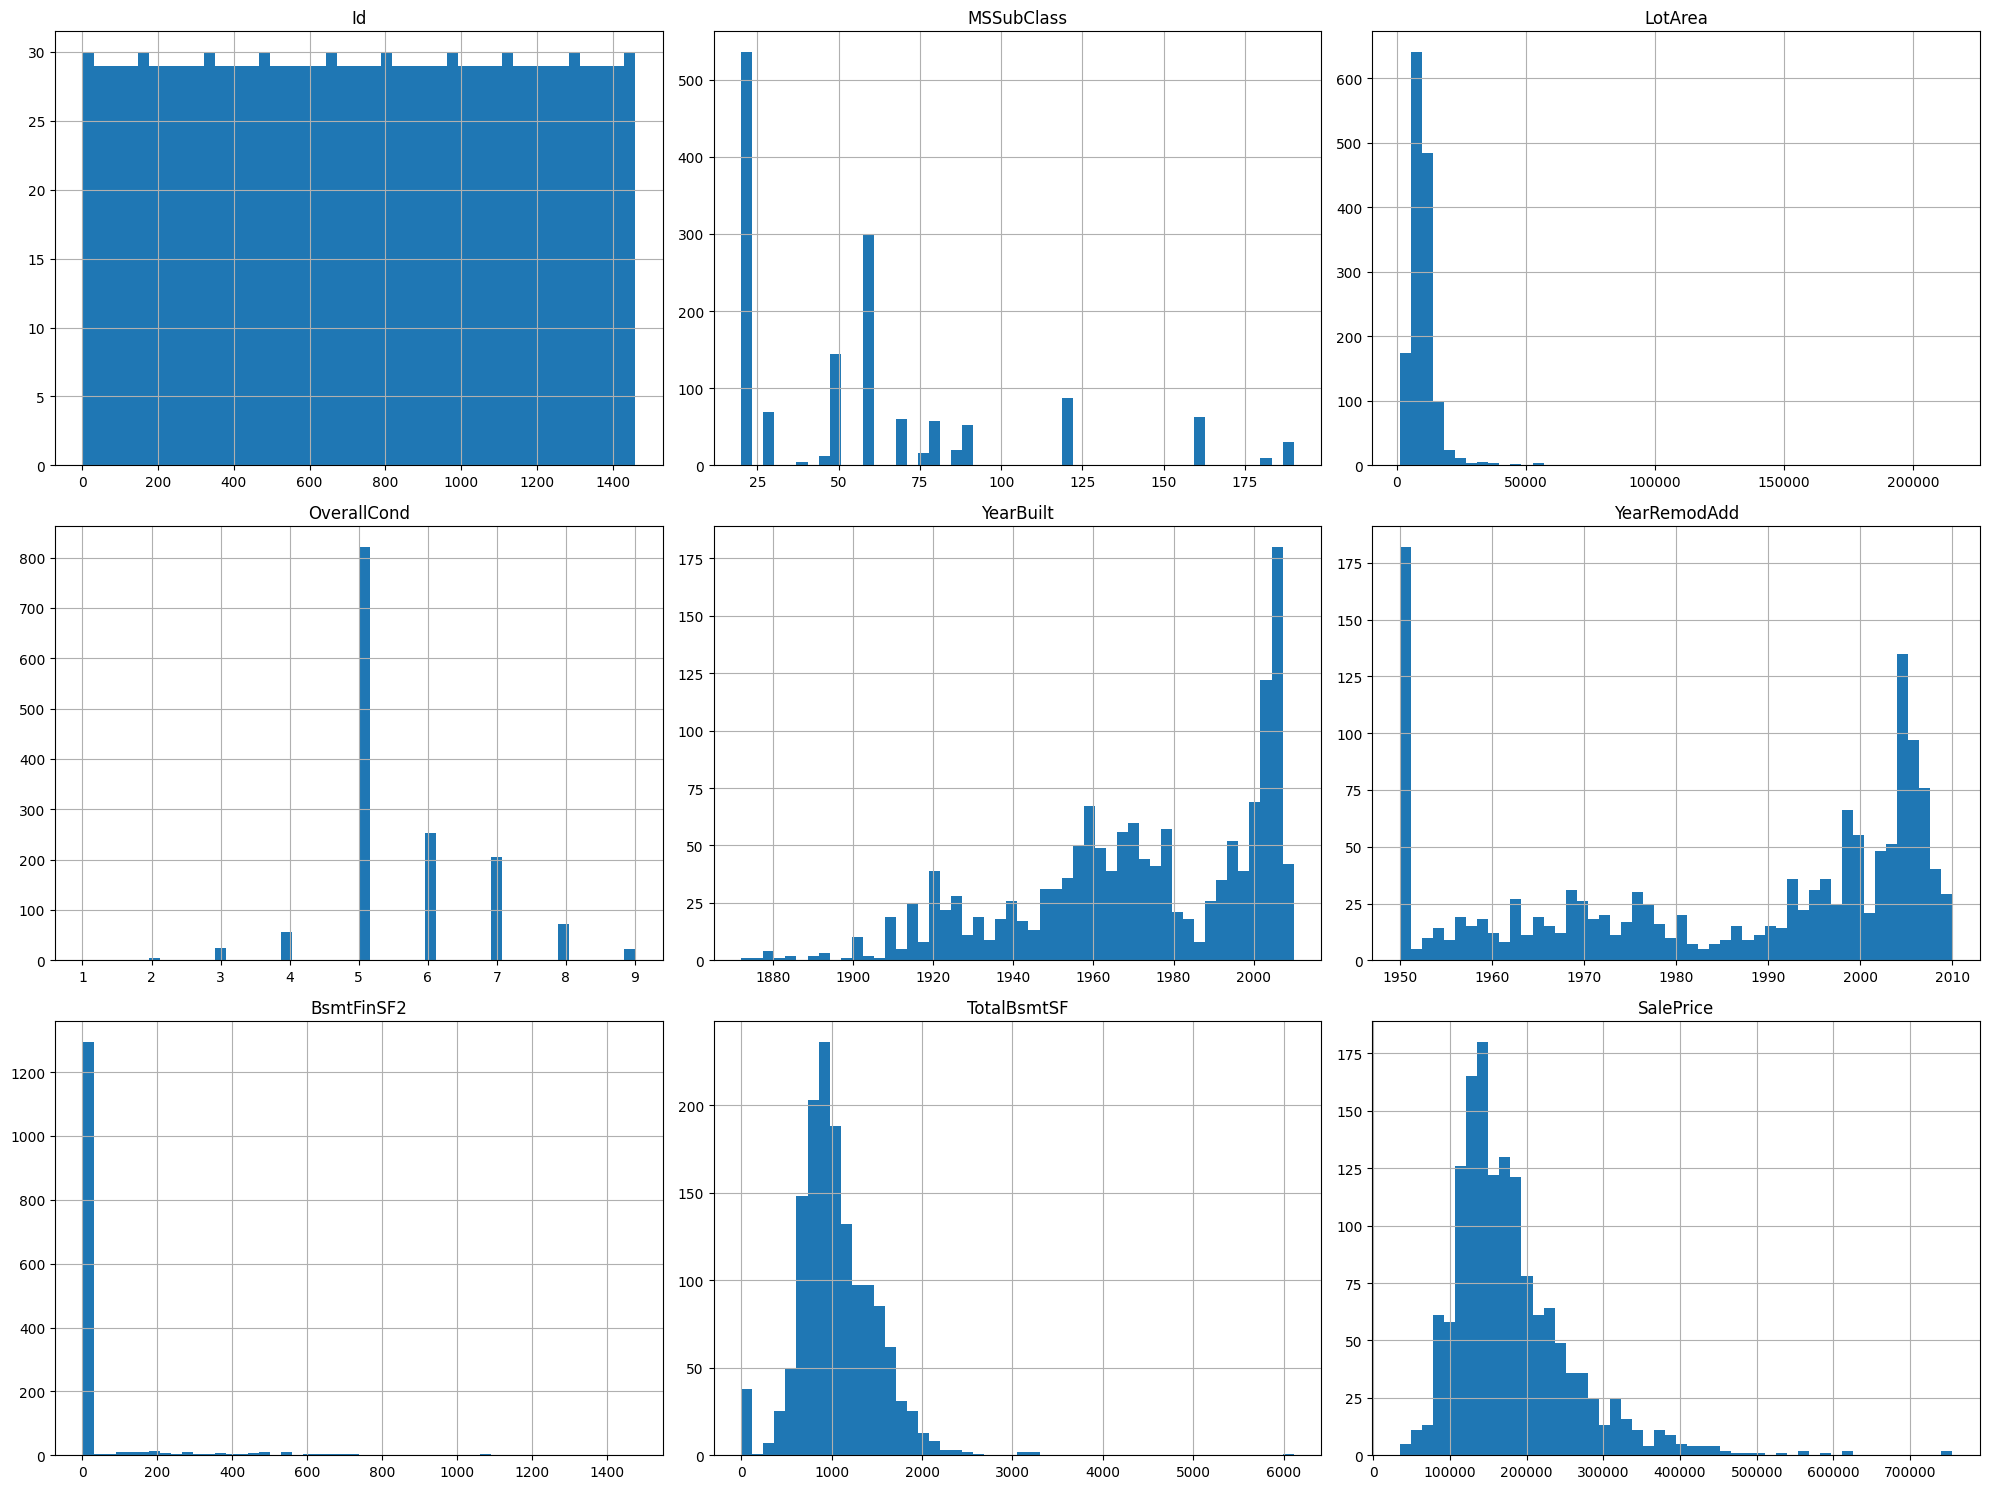

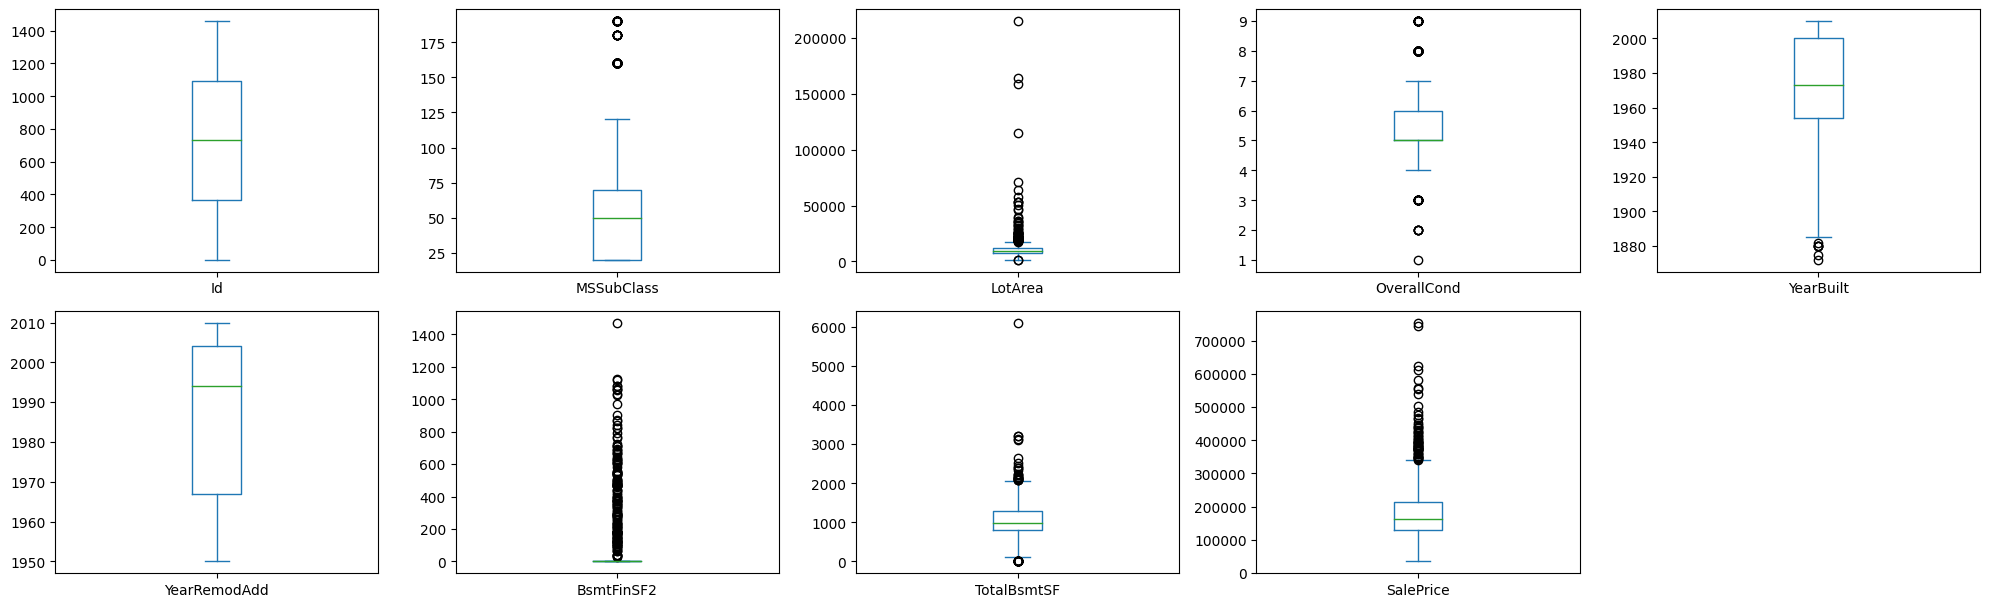

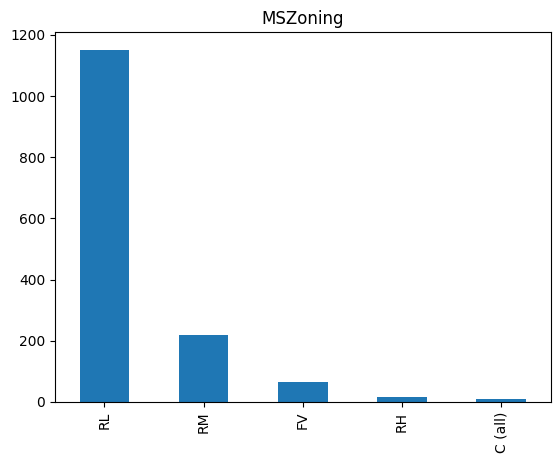

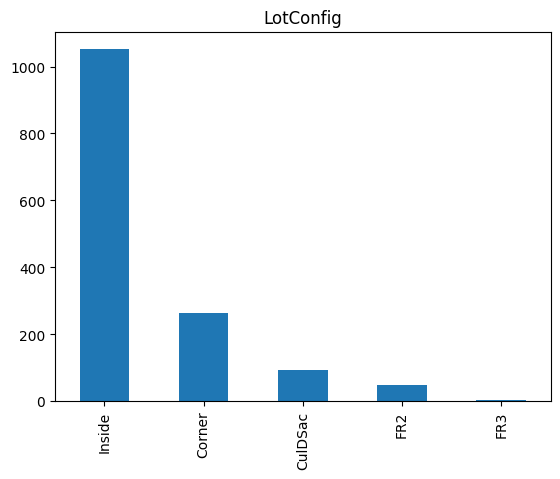

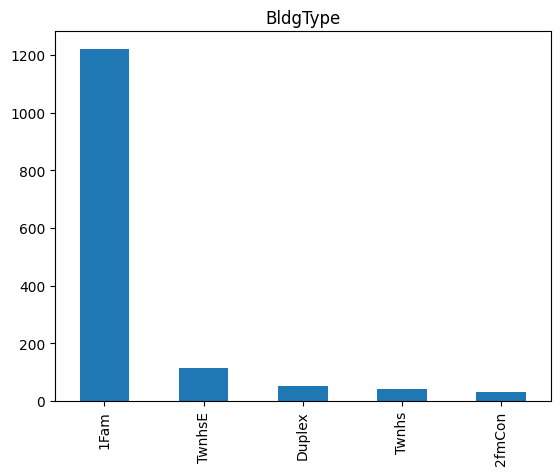

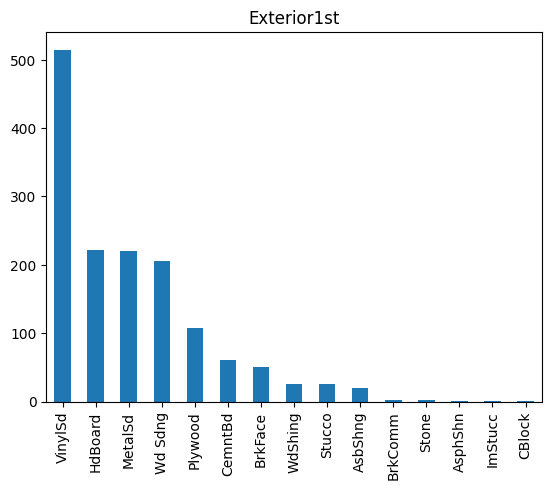

<ipython-input-37-6e0a5c467b67>:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_data.corr()


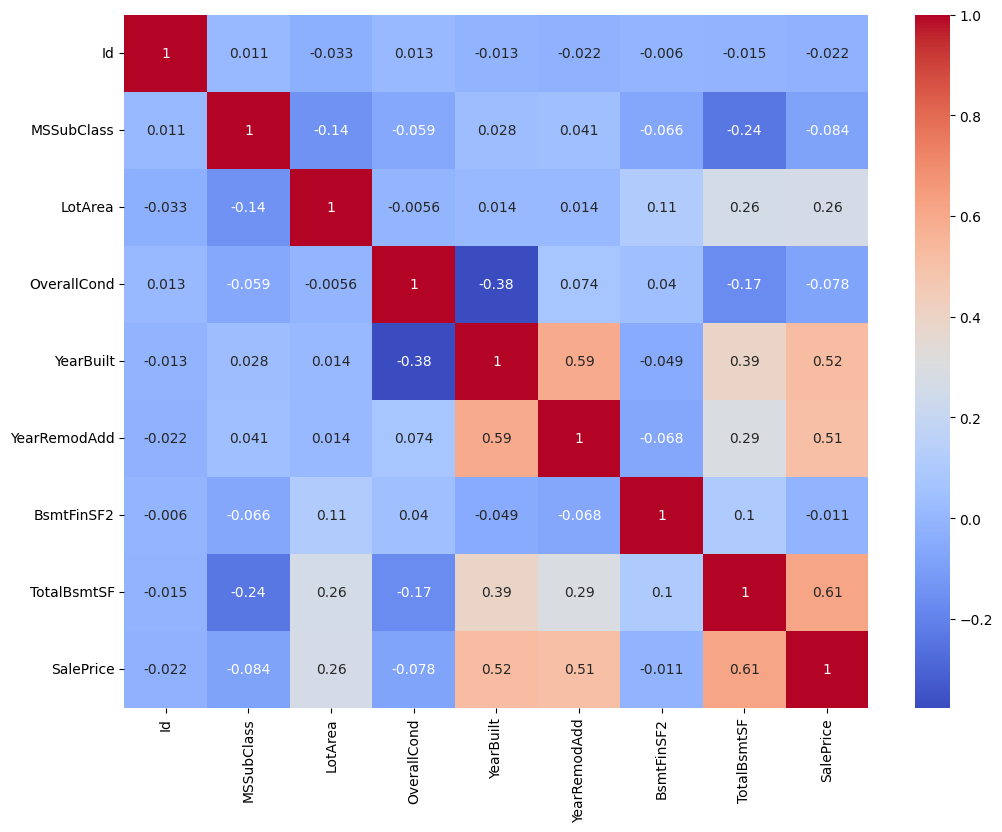

In [37]:
# Histograms for numerical columns
train_data.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

# Box plots for numerical columns
train_data.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,15))
plt.tight_layout()
plt.show()

for column in train_data.select_dtypes(include=['object']).columns:
    train_data[column].value_counts().plot(kind='bar', title=column)
    plt.show()

# Correlation matrix
corr_matrix = train_data.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


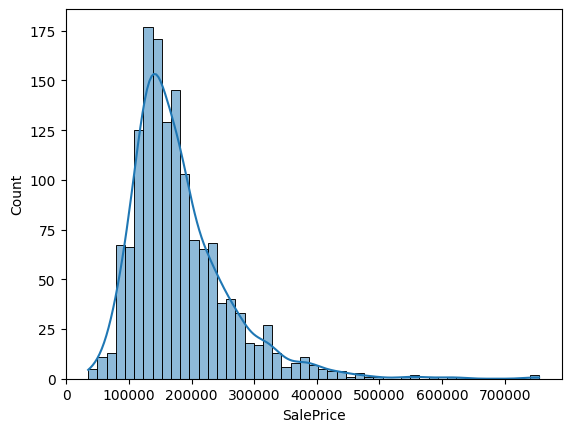

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [38]:
sns.histplot(train_data['SalePrice'], kde=True)
plt.show()

print('Skewness:', train_data['SalePrice'].skew())
print('Kurtosis:', train_data['SalePrice'].kurt())


In [8]:
predict_data.head()

,Id,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,BsmtFinSF2,TotalBsmtSF
1460,20,RH,11622,Inside,1Fam,6,1961,1961,VinylSd,144.0,882.0,NaN
1461,20,RL,14267,Corner,1Fam,6,1958,1958,Wd Sdng,0.0,1329.0,NaN
1462,60,RL,13830,Inside,1Fam,5,1997,1998,VinylSd,0.0,928.0,NaN
1463,60,RL,9978,Inside,1Fam,6,1998,1998,VinylSd,0.0,926.0,NaN
1464,120,RL,5005,Inside,TwnhsE,5,1992,1992,HdBoard,0.0,1280.0,NaN


## Data Preprocessing

In [33]:

def remove_outliers(data, col, val):
    del_rows = 0
    total_rows = len(data)
    if col in data.columns:
        for index, value in data[col].items():
            if value is None:
              value = data[col].mean()
            if int(value) > val:
                data.drop(index, inplace=True)
                del_rows +=1
    print(f"{del_rows/total_rows *100}% of rows removed due to outliers")
    return data

def clean_data(data):
    # remove the column id
    data = data.drop('Id', axis=1)

    if 'SalePrice' in data.columns:
        # Remove outliers based on a specific condition for 'SalePrice'
        data = remove_outliers(data, 'SalePrice', 700000)
        # Rename 'SalePrice' column to 'target'
        data = data.rename(columns={'SalePrice': 'target'})

    # Create a copy of the DataFrame for further cleaning
    df_transformed = data.copy()
    describe_to_dict = pd.DataFrame(df_transformed.describe().to_dict())

    # Drop rows with missing values in columns other than 'target'
    data.dropna(subset=df_transformed.columns[df_transformed.columns != 'target'], inplace=True)

    if 'target' in df_transformed.columns:
        # Impute missing values in 'target' column using the mean strategy
        imputer = SimpleImputer(strategy='mean')
        target = df_transformed['target'].values.reshape(-1, 1)
        imputer.fit(target)
        df_transformed['target'] = imputer.transform(target)

    # Perform one-hot encoding on categorical columns
    cat_cols = ['MSSubClass', 'MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
    df_transformed = pd.get_dummies(df_transformed, columns=cat_cols)

    # Calculate descriptive statistics of the transformed DataFrame
    describe_to_dict_verified = pd.DataFrame(df_transformed.describe().to_dict())

    return df_transformed, describe_to_dict, describe_to_dict_verified

def feature_engineer(data):
    # delete null columns and rows with null values
    data = data.dropna(axis=1, how='all')
    data = data.dropna(axis=0, how='any')

    # Ensure all other columns are of a numeric type, else convert them
    for col in data.columns:
        if data[col].dtype not in ['int64', 'float64']:
            data[col] = pd.to_numeric(data[col], errors='coerce')

    return data




In [34]:
# Apply the transformations
train_data_cleaned, train_raw_describe, train_cleaned_describe = clean_data(train_data)
train_data_engineered = feature_engineer(train_data_cleaned)

predict_data_cleaned, predict_raw_describe, predict_cleaned_describe = clean_data(predict_data)
predict_data_engineered = feature_engineer(predict_data_cleaned)

0.136986301369863% of rows removed due to outliers


## Data Split

In [39]:
from sklearn.model_selection import train_test_split

X = train_data_engineered.drop('target', axis=1)
y = train_data_engineered['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model Implementation

### Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


model = LinearRegression()

parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}

grid = GridSearchCV(model,parameters, cv=None)

# Fit the grid search
grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test)

print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('R^2 Score:', r2_score(y_test, y_pred))


{'copy_X': True, 'fit_intercept': True}
Mean Squared Error: 1430452741.00102
Mean Absolute Error: 28725.526945655514
R^2 Score: 0.7361435460330565


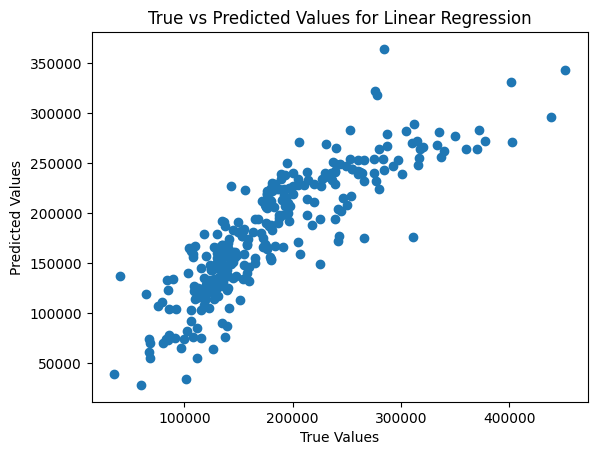

In [42]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for Linear Regression')
plt.show()


### Random Forest Regresson

In [43]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)

# Define the parameters for the grid search
parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(model, parameters, cv=5, n_jobs=-1)

# Fit the grid search
grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test)

print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('R^2 Score:', r2_score(y_test, y_pred))


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Mean Squared Error: 961735784.9937104
Mean Absolute Error: 21119.39286316772
R^2 Score: 0.8226014837064972


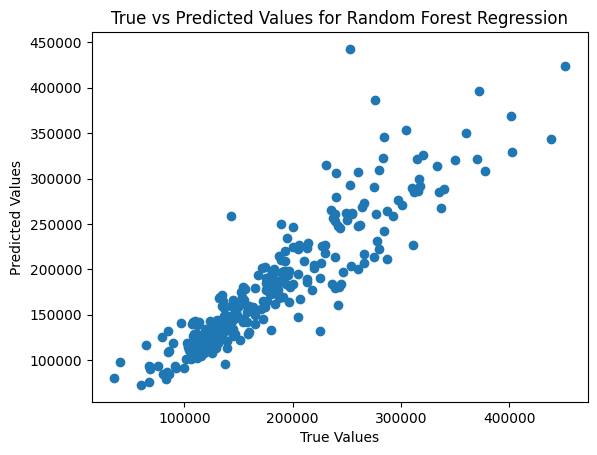

In [44]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for Random Forest Regression')
plt.show()


### Gradient Boosting

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=42)

# Define the parameters for the grid search
parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}


grid = GridSearchCV(model, parameters, cv=5, n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test)

print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('R^2 Score:', r2_score(y_test, y_pred))


{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 957721842.9597327
Mean Absolute Error: 20629.397006638974
R^2 Score: 0.8233418818204349


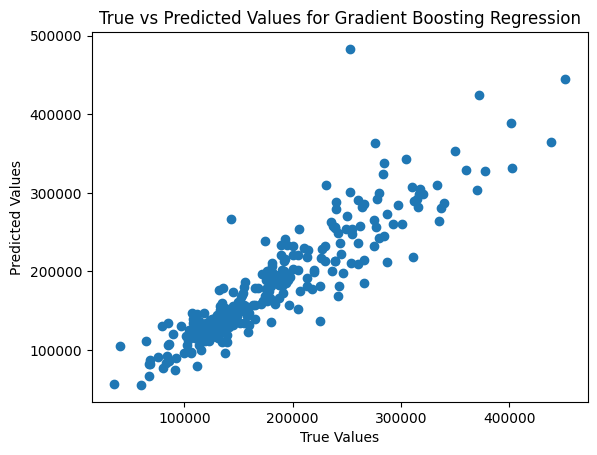

In [46]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for Gradient Boosting Regression')
plt.show()
